In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import *
import os
from utils_perso import load_data, initial_model



In [7]:
import torch

In [2]:
df2, df_intervals = load_data("data/train/", train = True)

#df = initial_model(df2)

In [3]:
df_intervals

[[(55613, 90222),
  (101241, 101544),
  (256613, 296764),
  (347872, 391785),
  (401269, 401475),
  (527030, 568054),
  (649037, 688258),
  (741955, 802294),
  (828360, 865777),
  (992950, 1019856),
  (1135027, 1180801),
  (1250239, 1250499),
  (1460336, 1520206)],
 [(38942, 70899),
  (101261, 101574),
  (246391, 292265),
  (326942, 354777),
  (452226, 503362),
  (528543, 584561),
  (601308, 601638),
  (727945, 754252),
  (845021, 905489),
  (989331, 1046260),
  (1147420, 1187292),
  (1307377, 1338467),
  (1454845, 1505710)]]

In [41]:

chunks = []
chunk_labels = []

for machine_id, data in df2.groupby("machine"):
    
    
    on_intervals = df_intervals[machine_id - 1]
    start = 0 
    for i, (start_on, stop) in enumerate(on_intervals):
        
        chunks.append(data["y"].iloc[start:start_on])
        chunk_labels.append(int(data["label"].iloc[start + 5]))

        if i == len(on_intervals)-1:
            break
        
        chunks.append(data["y"].iloc[start_on:stop])
        
        chunk_labels.append(int(data["label"].iloc[start_on + 5]))
        start = stop

    
len(chunk_labels)


50

In [56]:
samples = []
sample_labels = []
n = 100

for j, chunk in enumerate(chunks):
    sam = [chunk[i: i+n] for i in range(0, len(chunk), n) ]
    samples = samples +  sam
    sample_labels = sample_labels + [chunk_labels[i] for _ in range(len(sam)) ]

In [59]:

print(len(sample_labels))

AttributeError: 'list' object has no attribute 'shape'

In [60]:
samples_tensor = torch.tensor(samples, dtype = torch.float32)

ValueError: expected sequence of length 100 at dim 1 (got 13)

In [104]:
# Torch dataset definition

import torch
from torch.utils.data import Dataset, DataLoader

class SeriesDataset(Dataset):
    def __init__(self, chunks, labels):
        self.chunks = chunks
        self.labels = labels

    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        label = self.labels[idx]
        chunk = np.expand_dims(chunk, axis=0) 
        return torch.tensor(chunk, dtype = torch.float32), torch.tensor(label, dtype = torch.int8)


In [105]:
def collate_fn(batch):
    # Get the maximum sequence length in this batch
    max_length = max([x[0].size(1) for x in batch])
    
    # Pad sequences and create a tensor for labels
    padded_sequences = []
    labels = []

    for seq, label in batch:
        seq_length = seq.shape[1]
        # Pad sequences with zeros to match the maximum length in the batch
        padded_seq = torch.nn.functional.pad(seq, (0, max_length - seq_length))
        padded_sequences.append(padded_seq)
        labels.append(label)

    # Convert lists to tensors
    padded_sequences = torch.stack(padded_sequences)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    return padded_sequences, labels


In [115]:
dataset = SeriesDataset(samples, sample_labels)

train_loader = DataLoader(dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)

In [74]:
dataset[0][0].shape

torch.Size([100])

In [117]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        
        # Temporary tensor to calculate the flattened size
        self.example_input = torch.zeros(1, 1, 100)  # Adjust the sequence length (100) if necessary
        self.flattened_size = self._get_flattened_size(self.example_input)
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        return x.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

def train_model(model, train_loader, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Initialize and train the model
model = CNNModel()
train_model(model, train_loader)


Epoch 1/10:   0%|          | 0/912 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 912/912 [00:06<00:00, 150.36it/s]


Epoch 1, Loss: 22.365461884883413


Epoch 2/10: 100%|██████████| 912/912 [00:09<00:00, 91.98it/s] 


Epoch 2, Loss: 0.0


Epoch 3/10: 100%|██████████| 912/912 [00:09<00:00, 92.95it/s] 


Epoch 3, Loss: 0.0


Epoch 4/10: 100%|██████████| 912/912 [00:10<00:00, 90.92it/s] 


Epoch 4, Loss: 0.0


Epoch 5/10: 100%|██████████| 912/912 [00:09<00:00, 92.03it/s] 


Epoch 5, Loss: 0.0


Epoch 6/10:  21%|██        | 188/912 [00:01<00:06, 103.56it/s]


KeyboardInterrupt: 

In [116]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        
        # Temporary tensor to calculate the flattened size
        self.example_input = torch.zeros(1, 1, 100)  # Adjust the sequence length (100) if necessary
        self.flattened_size = self._get_flattened_size(self.example_input)
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_flattened_size(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        return x.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


def train_model(model, train_loader, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Initialize and train the model
model = CNNModel()
train_model(model, train_loader, num_epochs=10)

TypeError: 'module' object is not callable

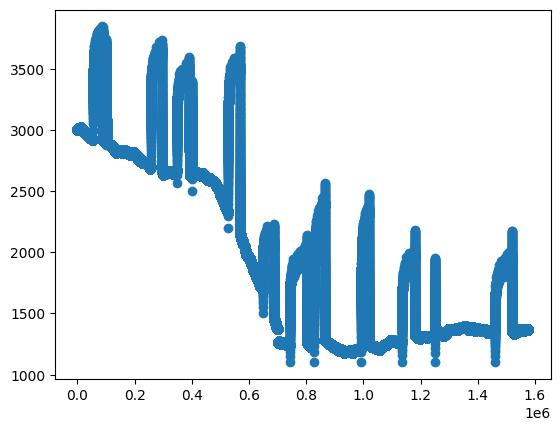

In [43]:
plt.scatter(range(len(df2[df2["machine"] == 1]["y"])), df2[df2["machine"] == 1]["y"])
plt.show()

In [ ]:
# data splits 

